# 결측치 다루기
* [Missing data - Wikipedia](https://en.wikipedia.org/wiki/Missing_data)
* 예제 데이터 다운로드 : https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
import numpy as np
import missingno as msno # 누락 된 데이터를 시각화 해주기 위해

import sys
print(sys.version)
print(pd.__version__)
print(np.__version__)
print(msno.__version__)

3.6.1 (v3.6.1:69c0db5050, Mar 21 2017, 01:21:04) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]
0.21.0
1.14.0
0.3.5


In [2]:
# 판다스를 통해 데이터를 로드해 온다.
# 여기에서는 캐글의 타이타닉 데이터를 사용한다. 
# 데이터 다운로드 : https://www.kaggle.com/c/titanic/data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


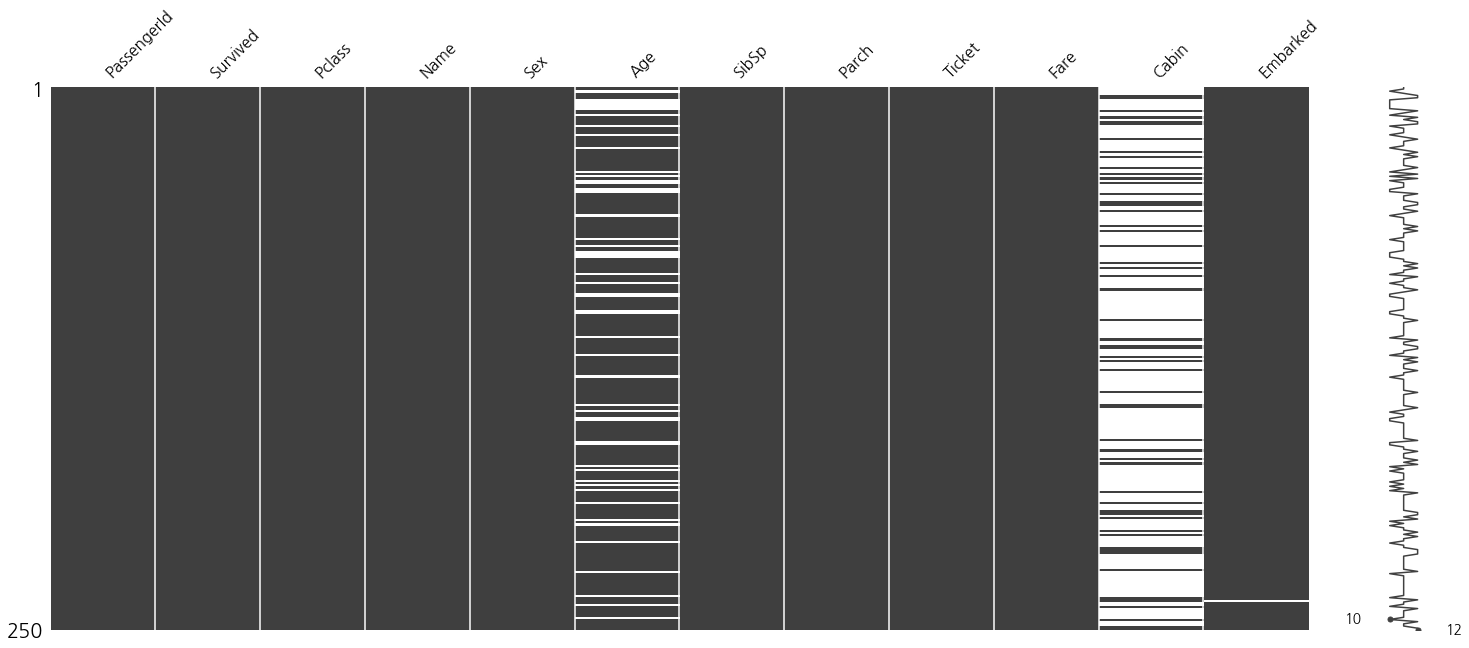

In [5]:
# 결측치를 시각화
%matplotlib inline
train = train.replace("nan", np.nan)
msno.matrix(train.sample(250))

In [6]:
# null 값 여부를 조회해 볼 수 있다.
train.isnull().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 1. 중간값이나 평균값으로 채워줌

In [9]:
train_mean = train.copy(deep = True)
test_mean = test.copy(deep = True)

In [10]:
train_mean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
def data_fillna(dataset):
    # 중간값으로 누락된 나이 데이터를 채워준다.
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    # 나머지 값으로 누락된 승선위치를 채워준다.
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    # 중간값으로 누락된 요금을 채워준다.
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

In [12]:
data_fillna(train_mean)
data_fillna(test_mean)

In [13]:
print(train.isnull().sum())
print('-'*20)
print(train_mean.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


### 2. 사이킷런의 Imputer 를 사용

In [14]:
train_imputer = train.copy()
test_imputer = test.copy()

In [15]:
from sklearn.preprocessing import Imputer

# 결측치를 보완해 준다.
def nan_padding(data, columns):
    for column in columns:
        imputer = Imputer()
        data[column] = imputer.fit_transform(data[column].values.reshape(-1,1))
    return data


nan_columns = ["Age", "SibSp", "Parch", "Fare"]

train_imputer = nan_padding(train_imputer, nan_columns)
test_imputer = nan_padding(test_imputer, nan_columns)

In [16]:
print(train.isnull().sum())
print('-'*10)
print(train_imputer.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [17]:
train_imputer[nan_columns].head()

,Age,SibSp,Parch,Fare
0,22.0,1.0,0.0,7.2500
1,38.0,1.0,0.0,71.2833
2,26.0,0.0,0.0,7.9250
3,35.0,1.0,0.0,53.1000
4,35.0,0.0,0.0,8.0500


### 3. 머신러닝 기법을 사용